In [1]:
import numpy as np
import pandas as pd

In [6]:
with np.load('data\AAPL_Technical_30mins.npz') as data:
    print(data.keys)
    X = data['X']
    Y = data['Y']
print(X.shape)
print(Y.shape)

<bound method Mapping.keys of <numpy.lib.npyio.NpzFile object at 0x00000262FDC1CAF0>>
(4450, 14, 5)
(4450,)


In [3]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import yfinance
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

2023-01-19 12:29:29.195973: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow version: 2.10.0


/var/folders/7m/30kl80f51jj8dn74qt_xgy740000gn/T/ipykernel_70900/3235336768.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [48]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [49]:
def format(x):
    x.replace('Z', '')
    splitted = x.split('T')
    return splitted[0] + " " + splitted[1][:-1]

In [50]:
df = yfinance.download('aapl')
df['Date'] = df.index
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.128348,0.128906,0.128348,0.128348,0.099874,469033600,1980-12-12 00:00:00-05:00
1980-12-15 00:00:00-05:00,0.122210,0.122210,0.121652,0.121652,0.094663,175884800,1980-12-15 00:00:00-05:00
1980-12-16 00:00:00-05:00,0.113281,0.113281,0.112723,0.112723,0.087715,105728000,1980-12-16 00:00:00-05:00
1980-12-17 00:00:00-05:00,0.115513,0.116071,0.115513,0.115513,0.089886,86441600,1980-12-17 00:00:00-05:00
1980-12-18 00:00:00-05:00,0.118862,0.119420,0.118862,0.118862,0.092492,73449600,1980-12-18 00:00:00-05:00
...,...,...,...,...,...,...,...
2023-01-11 00:00:00-05:00,131.250000,133.509995,130.460007,133.490005,133.490005,69458900,2023-01-11 00:00:00-05:00
2023-01-12 00:00:00-05:00,133.880005,134.259995,131.440002,133.410004,133.410004,71379600,2023-01-12 00:00:00-05:00
2023-01-13 00:00:00-05:00,132.029999,134.919998,131.660004,134.759995,134.759995,57758000,2023-01-13 00:00:00-05:00


In [51]:
ticker = 'aapl'
df = yfinance.download(ticker)
df = df.rename(columns={'Open':'open', 'High': 'high', 'Low':'low', 'Close':'close', 'Volume':'volume'})
df['date_time'] = df.index
df = df.reset_index()
df = df.drop(columns=['Date', 'Adj Close'])

# df = pd.read_csv(IBM_path, delimiter=',', usecols=['date_time', 'open', 'high', 'low', 'close', 'volume'])

# Replace 0 to avoid dividing by 0 later on
df['volume'].replace(to_replace=0, method='ffill', inplace=True) 
# df['date_time'] = df['date_time'].apply(format)
# df['date_time'] = pd.to_datetime(df['date_time'], format="%Y-%m-%d %H:%M:%S")
df.sort_values('date_time', inplace=True)

df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume,date_time
9,0.129799,0.130246,0.129687,0.129687,114705920.0,1980-12-26 00:00:00-05:00
10,0.133036,0.133482,0.132924,0.132924,77118720.0,1980-12-29 00:00:00-05:00
11,0.136551,0.136998,0.136440,0.136440,66418240.0,1980-12-30 00:00:00-05:00
12,0.140513,0.140960,0.140402,0.140402,59420480.0,1980-12-31 00:00:00-05:00
13,0.144364,0.144866,0.144252,0.144252,52942400.0,1981-01-02 00:00:00-05:00


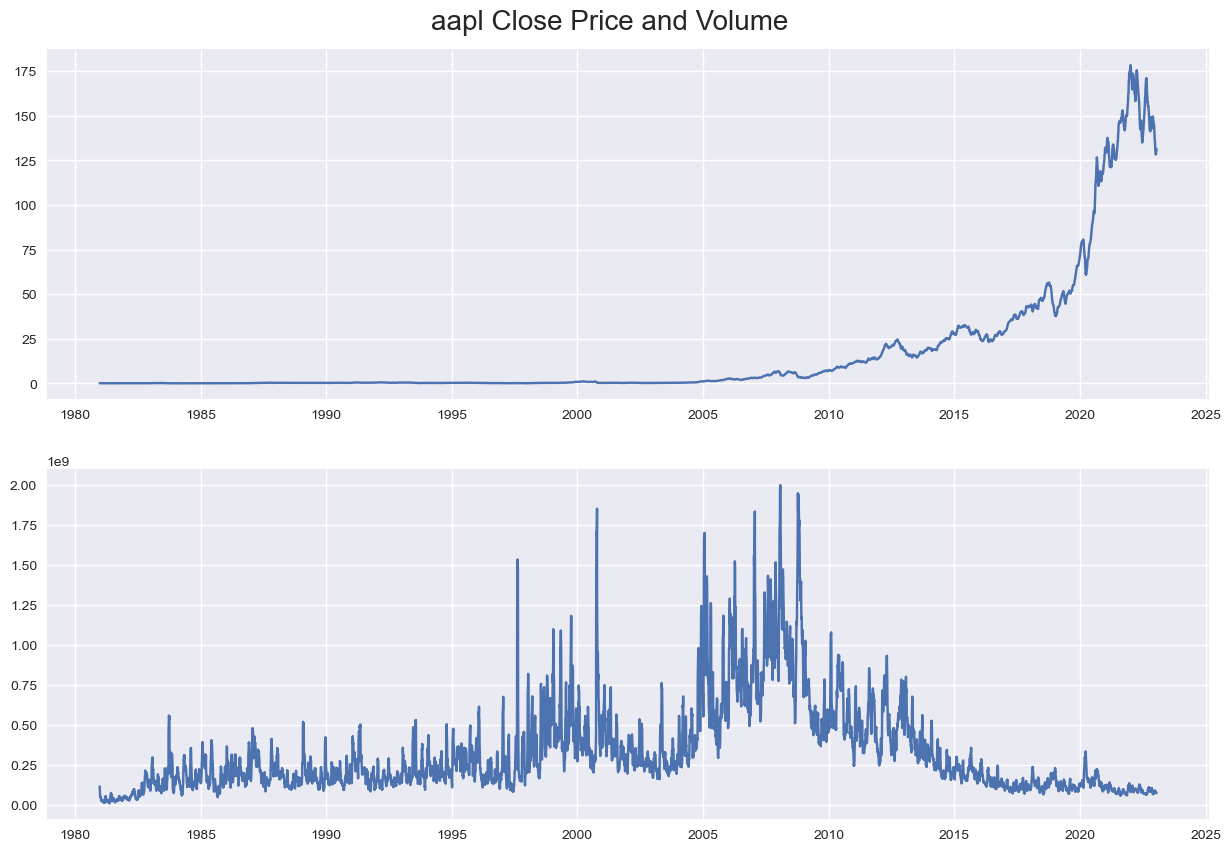

In [52]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle(f"{ticker} Close Price and Volume", fontsize=20)
st.set_y(0.92)

gap = 10000
ax1 = fig.add_subplot(211)
ax1.plot(df['date_time'], df['close'], label=f'{ticker} Close Price')

ax2 = fig.add_subplot(212)
ax2.plot(df['date_time'], df['volume'], label=f'{ticker} Volume')

In [53]:
df['open'] = df['open'].pct_change() # Create arithmetic returns column
df['high'] = df['high'].pct_change() # Create arithmetic returns column
df['low'] = df['low'].pct_change() # Create arithmetic returns column
df['close'] = df['close'].pct_change() # Create arithmetic returns column
df['volume'] = df['volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

min_return = min(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].min(axis=0))
max_return = max(df[(df.index < last_20pct)][['open', 'high', 'low', 'close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['open'] = (df['open'] - min_return) / (max_return - min_return)
df['high'] = (df['high'] - min_return) / (max_return - min_return)
df['low'] = (df['low'] - min_return) / (max_return - min_return)
df['close'] = (df['close'] - min_return) / (max_return - min_return)

min_volume = df[(df.index < last_20pct)]['volume'].min(axis=0)
max_volume = df[(df.index < last_20pct)]['volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['volume'] = (df['volume'] - min_volume) / (max_volume - min_volume)

df

,open,high,low,close,volume,date_time
10,0.766722,0.766301,0.766827,0.766827,0.069854,1980-12-29 00:00:00-05:00
11,0.774055,0.773620,0.774165,0.774165,0.164642,1980-12-30 00:00:00-05:00
12,0.786797,0.786331,0.786913,0.786913,0.181396,1980-12-31 00:00:00-05:00
13,0.778863,0.780384,0.778970,0.778970,0.179558,1981-01-02 00:00:00-05:00
14,0.754343,0.752066,0.752525,0.752525,0.198508,1981-01-05 00:00:00-05:00
...,...,...,...,...,...,...
10609,0.643534,0.651947,0.650789,0.657304,0.234534,2023-01-11 00:00:00-05:00
10610,0.660109,0.656188,0.665637,0.672228,0.225570,2023-01-12 00:00:00-05:00
10611,0.659409,0.660701,0.659209,0.663622,0.222973,2023-01-13 00:00:00-05:00
10612,0.668393,0.671496,0.669828,0.666803,0.225693,2023-01-17 00:00:00-05:00


In [54]:
df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Remove date column
df_train.drop(columns=['date_time'], inplace=True)
df_val.drop(columns=['date_time'], inplace=True)
df_test.drop(columns=['date_time'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (8484, 5)
Validation data shape: (1060, 5)
Test data shape: (1060, 5)


,open,high,low,close,volume
10,0.766722,0.766301,0.766827,0.766827,0.069854
11,0.774055,0.773620,0.774165,0.774165,0.164642
12,0.786797,0.786331,0.786913,0.786913,0.181396
13,0.778863,0.780384,0.778970,0.778970,0.179558
14,0.754343,0.752066,0.752525,0.752525,0.198508


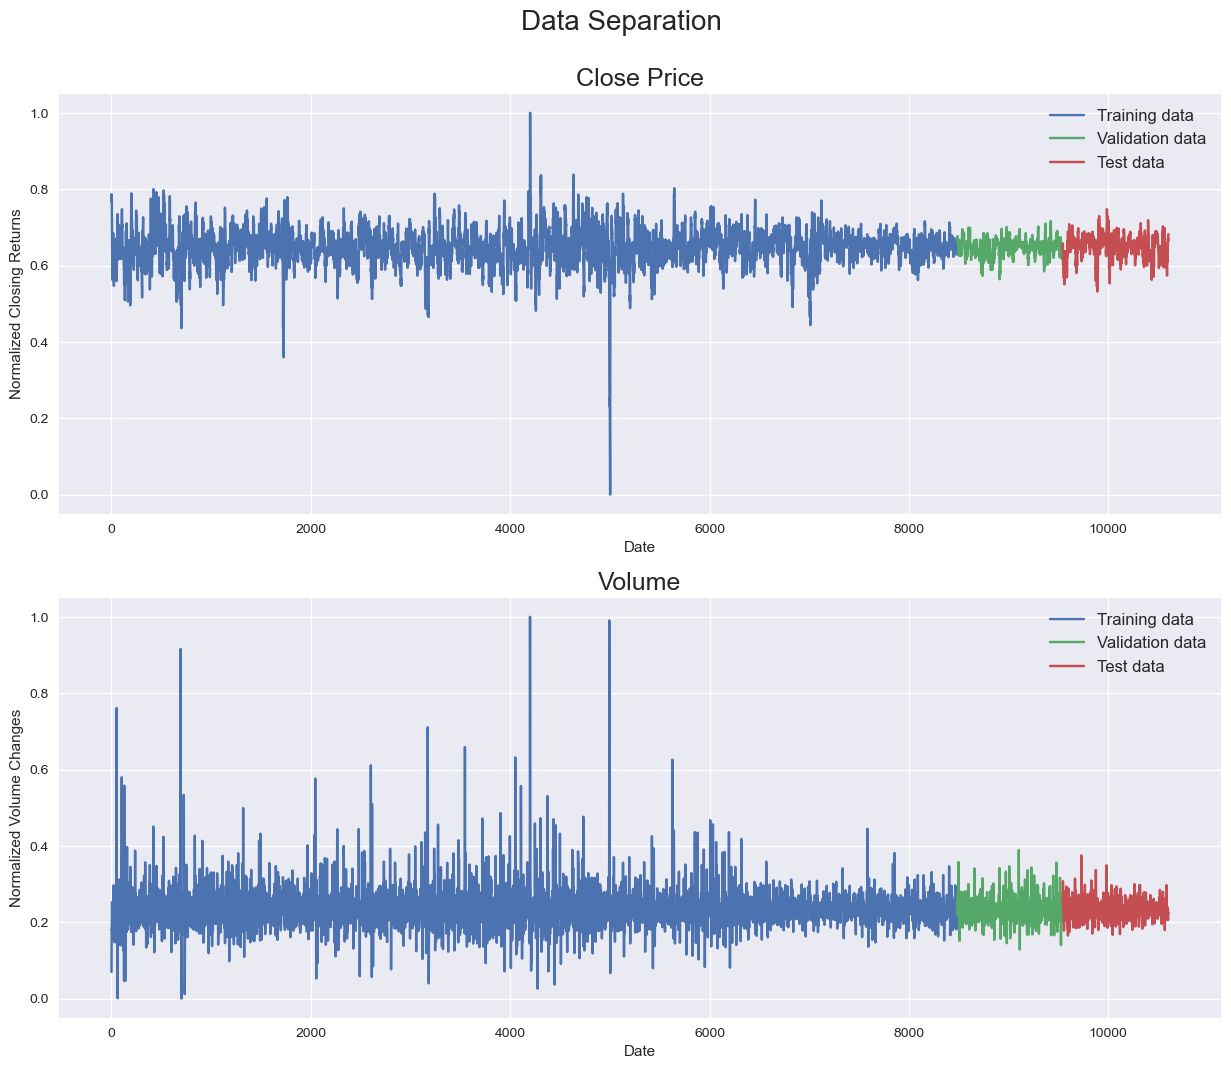

In [55]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

In [56]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (8356, 128, 5) (8356,)
Validation set shape (932, 128, 5) (932,)
Testing set shape (932, 128, 5) (932,)


In [57]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [58]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config  

In [59]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 5)]     0           []                               
                                                                                                  
 time2_vector_2 (Time2Vector)   (None, 128, 2)       512         ['input_2[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 128, 7)       0           ['input_2[0][0]',                
                                                                  'time2_vector_2[0][0]']         
                                                                                                  
 transformer_encoder_6 (Transfo  (None, 128, 7)      99114       ['concatenate_1[0][0]',    

Epoch 15/35
262/262 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0398 - mape: 82112.4141
Epoch 15: val_loss did not improve from 0.00049
262/262 [==============================] - 215s 819ms/step - loss: 0.0028 - mae: 0.0398 - mape: 82112.4141 - val_loss: 4.9257e-04 - val_mae: 0.0171 - val_mape: 2.6553
Epoch 16/35
262/262 [==============================] - ETA: 0s - loss: 0.0028 - mae: 0.0395 - mape: 77484.3125
Epoch 16: val_loss did not improve from 0.00049
262/262 [==============================] - 209s 797ms/step - loss: 0.0028 - mae: 0.0395 - mape: 77484.3125 - val_loss: 4.9641e-04 - val_mae: 0.0170 - val_mape: 2.6501
Epoch 17/35
262/262 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0387 - mape: 74256.8906
Epoch 17: val_loss did not improve from 0.00049
262/262 [==============================] - 209s 799ms/step - loss: 0.0027 - mae: 0.0387 - mape: 74256.8906 - val_loss: 5.0810e-04 - val_mae: 0.0175 - val_mape: 2.7082
Epoch 18/35
262/262 [=

30/30 [==============================] - 8s 250ms/step
 
Evaluation metrics
Training Data - Loss: 0.0006, MAE: 0.0171, MAPE: 22211.7188
Validation Data - Loss: 0.0001, MAE: 0.0093, MAPE: 1.4509
Test Data - Loss: 0.0002, MAE: 0.0119, MAPE: 1.8616


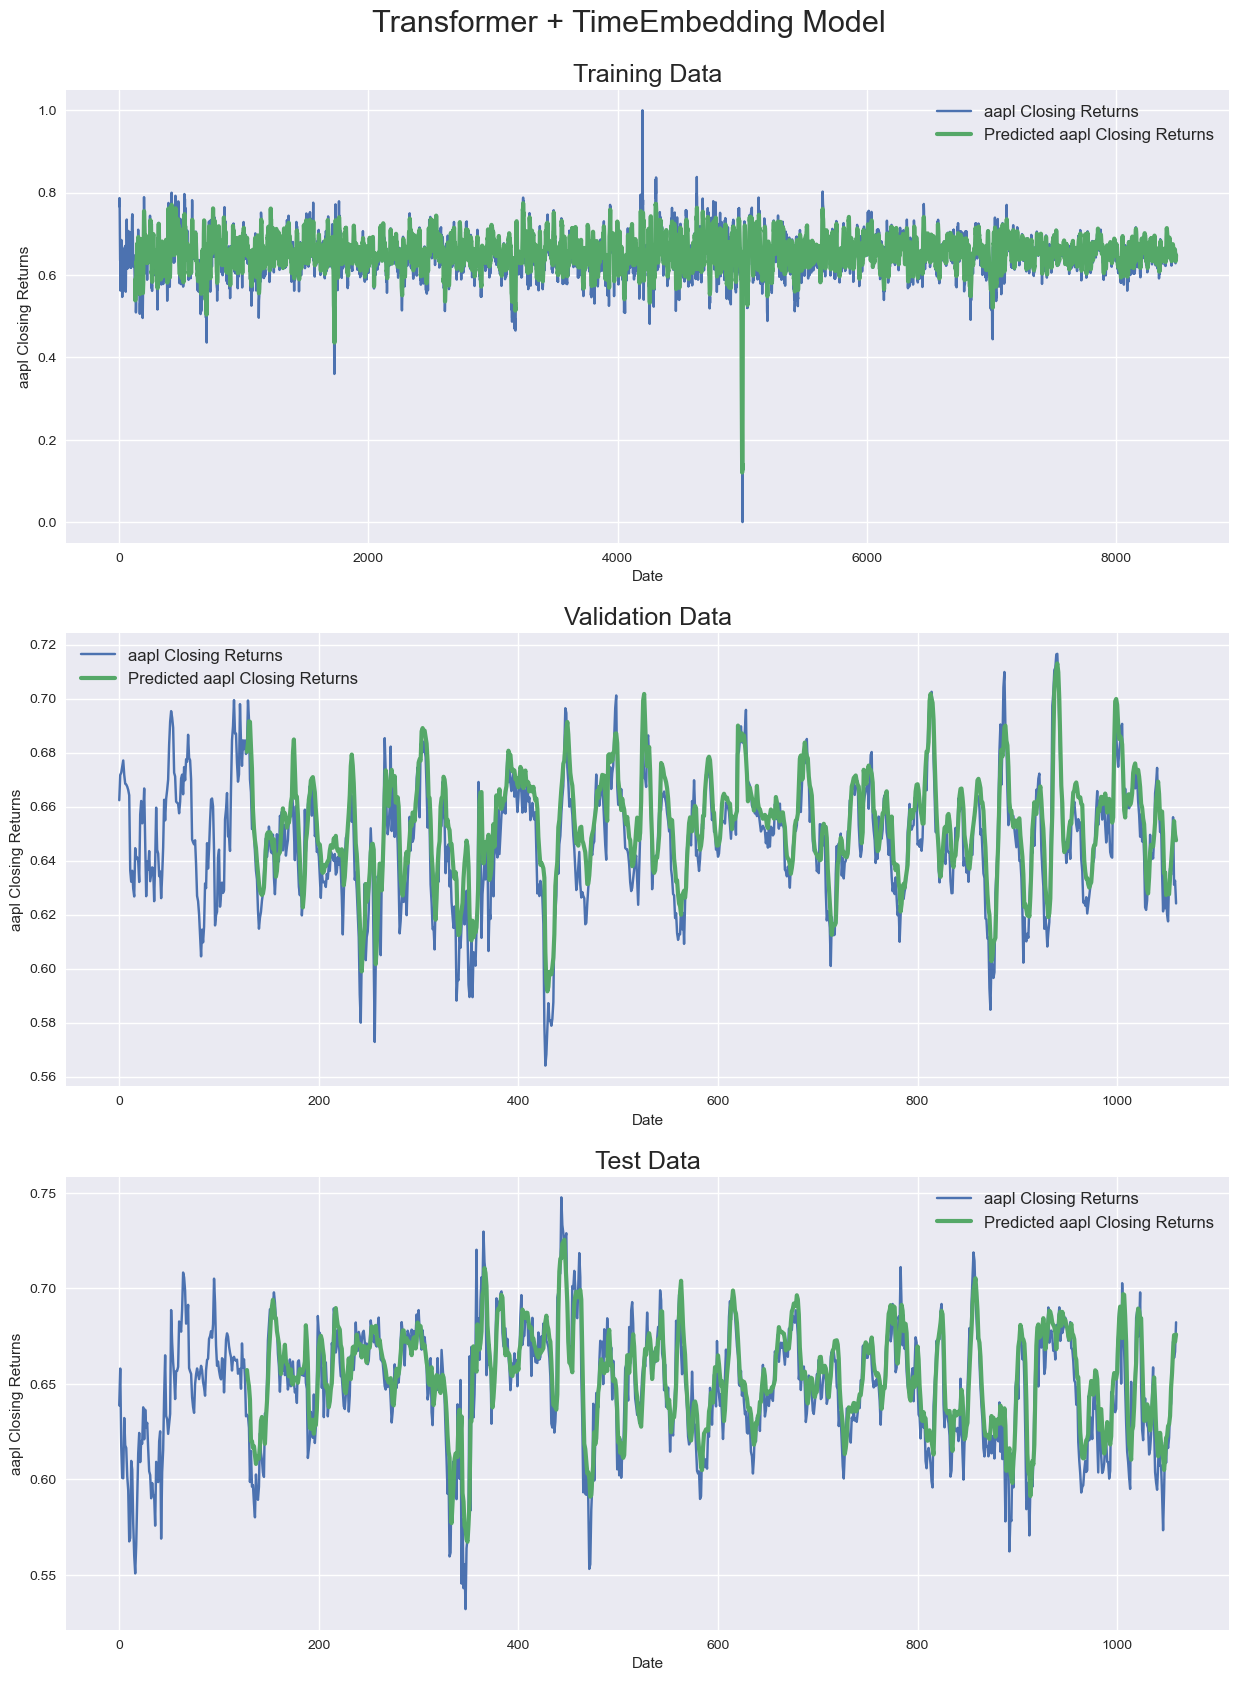

In [60]:
model = tf.keras.models.load_model('Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label=f'{ticker} Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label=f'Predicted {ticker} Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel(f'{ticker} Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label=f'{ticker} Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label=f'Predicted {ticker} Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel(f'{ticker} Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label=f'{ticker} Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label=f'Predicted {ticker} Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel(f'{ticker} Closing Returns')
ax31.legend(loc="best", fontsize=12)

In [65]:
print(test_pred.shape)
print(test_data[128:,3].shape)
test_pred_sign = test

(932, 1)
(932,)


In [61]:
fig.savefig(f'{ticker}.png')

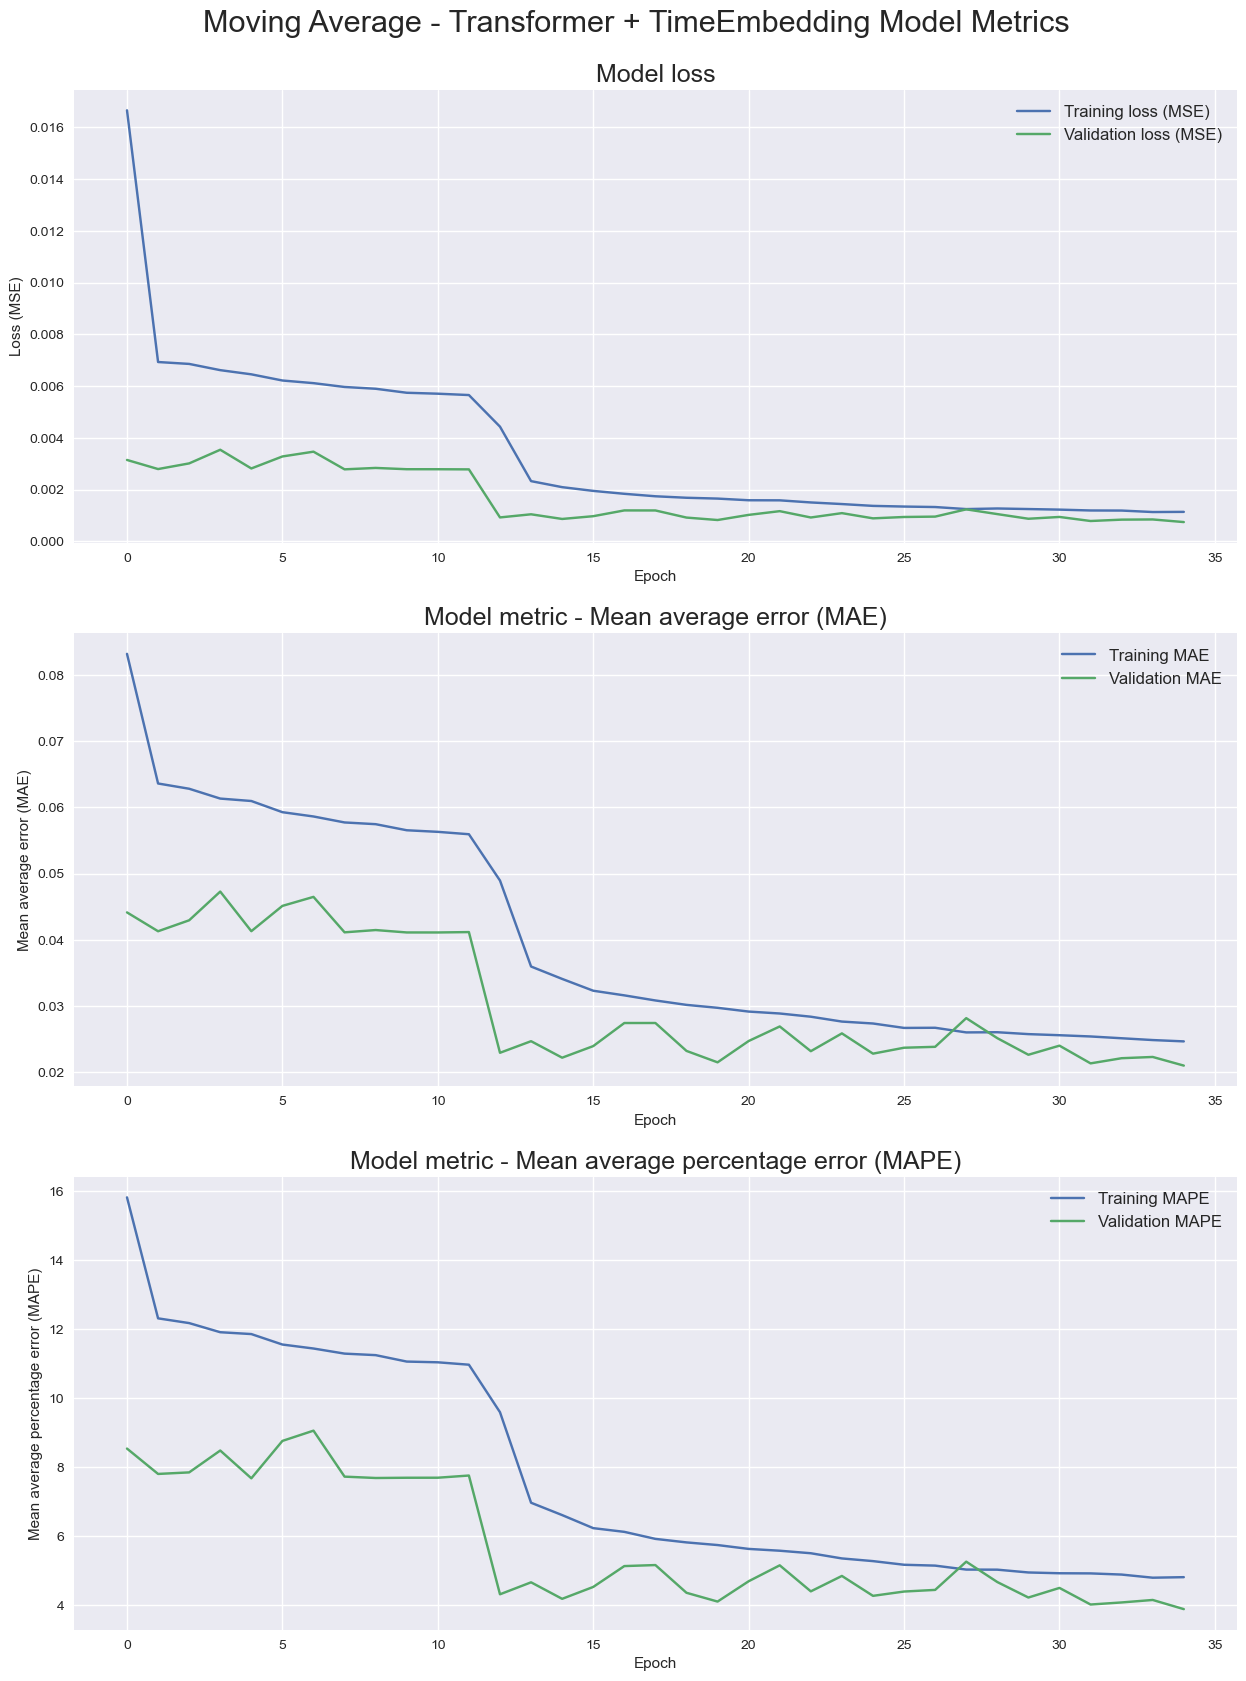

In [47]:

'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)
     